# ML pipeline

Here, we automate the end-to-end ML workflow using Amazon SageMaker Pipelines and the Amazon SageMaker Model Registry.

In [79]:
import pandas as pd
import json
import boto3
import pathlib
import io
import sagemaker
from time import gmtime, strftime, sleep
from sagemaker.deserializers import CSVDeserializer
from sagemaker.serializers import CSVSerializer

from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import (
    ProcessingInput, 
    ProcessingOutput, 
    ScriptProcessor
)
from sagemaker.inputs import TrainingInput

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import (
    ProcessingStep, 
    TrainingStep, 
    CreateModelStep
)
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.parameters import (
    ParameterInteger, 
    ParameterFloat, 
    ParameterString, 
    ParameterBoolean
)
from sagemaker.workflow.clarify_check_step import (
    ModelBiasCheckConfig, 
    ClarifyCheckStep, 
    ModelExplainabilityCheckConfig
)
from sagemaker import Model
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.conditions import (
    ConditionGreaterThan,
    ConditionGreaterThanOrEqualTo
)
from sagemaker.workflow.pipeline_experiment_config import PipelineExperimentConfig
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import (
    Join,
    JsonGet
)
from sagemaker.workflow.lambda_step import (
    LambdaStep,
    LambdaOutput,
    LambdaOutputTypeEnum,
)
from sagemaker.lambda_helper import Lambda

from sagemaker.model_metrics import (
    MetricsSource, 
    ModelMetrics, 
    FileSource
)
from sagemaker.drift_check_baselines import DriftCheckBaselines

from sagemaker.image_uris import retrieve

sagemaker.__version__

'2.199.0'

In [80]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN setup.ipynb notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Stored variables and their in-db values:
baseline_s3_url                        -> 's3://mathujan-mlproject/mlproject/xgboost/baselin
bucket_name                            -> 'mathujan-mlproject'
bucket_prefix                          -> 'mlproject/xgboost'
domain_id                              -> 'd-zidnh705pfd0'
evaluation_s3_url                      -> 's3://mathujan-mlproject/mlproject/xgboost/evaluat
initialized                            -> True
input_s3_url                           -> 's3://mathujan-mlproject/mlproject/xgboost/input/b
model_package_group_name               -> 'mathujan-mlproject-model-group'
output_s3_url                          -> 's3://mathujan-mlproject/mlproject/xgboost/output'
prediction_baseline_s3_url             -> 's3://mathujan-mlproject/mlproject/xgboost/predict
region                                 -> 'eu-north-1'
sm_role                                -> 'arn:aws:iam::058264187904:role/service-role/Amazo
test_s3_url                            -

## Set constants

In [81]:
# Set names of pipeline objects
project = "mathujan-mlproject"

pipeline_name = f"{project}-pipeline"
pipeline_model_name = f"{project}-model-xgb"
model_package_group_name = f"{project}-model-group"
endpoint_config_name = f"{project}-endpoint-config"
endpoint_name = f"{project}-endpoint"

In [82]:
# Set instance types and counts
process_instance_type = "ml.t3.medium"
train_instance_count = 1
train_instance_type = "ml.m5.xlarge"

In [83]:
# Set S3 urls for processed data
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"
baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"

evaluation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/evaluation"
prediction_baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/prediction_baseline"

output_s3_url = f"s3://{bucket_name}/{bucket_prefix}/output"

In [84]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url
%store model_package_group_name
%store evaluation_s3_url
%store prediction_baseline_s3_url
%store output_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)
Stored 'model_package_group_name' (str)
Stored 'evaluation_s3_url' (str)
Stored 'prediction_baseline_s3_url' (str)
Stored 'output_s3_url' (str)


In [85]:
print(f"Train S3 url: {train_s3_url}")
print(f"Validation S3 url: {validation_s3_url}")
print(f"Test S3 url: {test_s3_url}")
print(f"Data baseline S3 url: {baseline_s3_url}")
print(f"Evaluation metrics S3 url: {evaluation_s3_url}")
print(f"Model prediction baseline S3 url: {prediction_baseline_s3_url}")

Train S3 url: s3://mathujan-mlproject/mlproject/xgboost/train
Validation S3 url: s3://mathujan-mlproject/mlproject/xgboost/validation
Test S3 url: s3://mathujan-mlproject/mlproject/xgboost/test
Data baseline S3 url: s3://mathujan-mlproject/mlproject/xgboost/baseline
Evaluation metrics S3 url: s3://mathujan-mlproject/mlproject/xgboost/evaluation
Model prediction baseline S3 url: s3://mathujan-mlproject/mlproject/xgboost/prediction_baseline


For this project, we download the dataset from an online URL and store it in an S3 bucket. Thus, the S3 bucket serves as the data source for the project.

In [86]:
try:
    input_s3_url
except NameError:      
    # If input_s3_url is not defined, upload the dataset to S3 and store the path
    input_s3_url = sagemaker.Session().upload_data(
        path="data/bank-additional/bank-additional-full.csv",
        bucket=bucket_name,
        key_prefix=f"{bucket_prefix}/input"
    )
    print(f"Upload the dataset to {input_s3_url}")

    %store input_s3_url

## Create pipeline

### Setup pipeline parameters
SageMaker Pipelines supports parameterization, which allows you to specify input parameters at runtime without changing your pipeline code. You can use the parameter classes available under the `sagemaker.workflow.parameters` module.
Parameters have a default value, which you can override by specifying parameter values when starting a pipeline execution.

In [87]:
# Set processing instance type
process_instance_type_param = ParameterString(
    name="ProcessingInstanceType",
    default_value=process_instance_type,
)

# Set training instance type
train_instance_type_param = ParameterString(
    name="TrainingInstanceType",
    default_value=train_instance_type,
)

# Set training instance count
train_instance_count_param = ParameterInteger(
    name="TrainingInstanceCount",
    default_value=train_instance_count
)

# Set model approval param
model_approval_status_param = ParameterString(
    name="ModelApprovalStatus",
    default_value="PendingManualApproval"
)

# Minimal threshold for model performance on the test dataset
test_score_threshold_param = ParameterFloat(
    name="TestScoreThreshold", 
    default_value=0.75
)

# Set S3 url for input dataset
input_s3_url_param = ParameterString(
    name="InputDataUrl",
    default_value=input_s3_url,
)

### Build the pipeline steps
You include the following steps in the pipeline:
1. **Data processing step**: runs a SageMaker processing job for feature engineering and dataset split
1. **Training step**: runs a SageMaker training job using XGBoost algorithm
1. **Evaluation step**: evaluate the performance of the trained model
1. **Condition step**: checks if the performance of the model meets the specified threshold
1. **Register step**: registers a version of the model in the SageMaker model registry

In [88]:
session = PipelineSession()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


#### Processing step

In [89]:
%%writefile preprocessing.py

import pandas as pd
import numpy as np
import argparse
import os

def _parse_args():
    
    parser = argparse.ArgumentParser()
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    
    return parser.parse_known_args()


if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    
    target_col = "y"
    
    # Load data
    df_data = pd.read_csv(os.path.join(args.filepath, args.filename), sep=";")

    # Indicator variable to capture when pdays takes a value of 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicator for individuals not actively employed
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remove unnecessary data
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

    # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )

    # Shuffle and splitting dataset
    train_data, validation_data, test_data = np.split(
        df_model_data.sample(frac=1, random_state=1729),
        [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
    )

    print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
    
    # Save datasets locally
    train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    
    # Save the baseline dataset for model monitoring
    df_model_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)
    
    print("## Processing complete. Exiting.")

Overwriting preprocessing.py


In [90]:
sklearn_processor = SKLearnProcessor(
        framework_version="0.23-1",
        role=sm_role,
        instance_type=process_instance_type_param,
        instance_count=1,
        base_job_name=f"{pipeline_name}/preprocess",
        sagemaker_session=session,
    )
    
processing_inputs=[
    ProcessingInput(source=input_s3_url_param, destination="/opt/ml/processing/input")
]

processing_outputs=[
    ProcessingOutput(output_name="train_data", source="/opt/ml/processing/output/train", 
                     destination=train_s3_url),
    ProcessingOutput(output_name="validation_data", source="/opt/ml/processing/output/validation",
                     destination=validation_s3_url),
    ProcessingOutput(output_name="test_data", source="/opt/ml/processing/output/test",
                     destination=test_s3_url),
    ProcessingOutput(output_name="baseline_data", source="/opt/ml/processing/output/baseline", 
                     destination=baseline_s3_url),
]

processor_args = sklearn_processor.run(
    inputs=processing_inputs,
    outputs=processing_outputs,
    code='preprocessing.py',
)
    
# Define processing step
step_process = ProcessingStep(
    name=f"{pipeline_name}-preprocess-data",
    step_args=processor_args,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


#### Training step

In [91]:
xgboost_image_uri = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.5-1")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [92]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=xgboost_image_uri,
    role=sm_role, 
    instance_type=train_instance_type_param,
    instance_count=train_instance_count_param,
    output_path=output_s3_url,
    sagemaker_session=session,
    base_job_name=f"{pipeline_name}/train",
)

# Define algorithm hyperparameters
estimator.set_hyperparameters(
    num_round=150, # the number of rounds to run the training
    max_depth=5, # maximum depth of a tree
    eta=0.5, # step size shrinkage used in updates to prevent overfitting
    alpha=2.5, # L1 regularization term on weights
    objective="binary:logistic",
    eval_metric="auc", # evaluation metrics for validation data
    subsample=0.8, # subsample ratio of the training instance
    colsample_bytree=0.8, # subsample ratio of columns when constructing each tree
    min_child_weight=3, # minimum sum of instance weight (hessian) needed in a child
    early_stopping_rounds=10, # the model trains until the validation score stops improving
    verbosity=1, # verbosity of printing messages
)

training_inputs = {
    "train": TrainingInput(
        s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
            "train_data"
        ].S3Output.S3Uri,
        content_type="text/csv",
    ),
    "validation": TrainingInput(
        s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
            "validation_data"
        ].S3Output.S3Uri,
        content_type="text/csv",
    ),
}

training_args = estimator.fit(training_inputs)

# Define training step
step_train = TrainingStep(
    name=f"{pipeline_name}-train",
    step_args=training_args
)

#### Evaluation step
Create a model evaluation script to check if the model performance meets the specified threshold. 

In [93]:
%%writefile evaluation.py

import json
import os
import pathlib
import pickle as pkl
import tarfile
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime as dt
from sklearn.metrics import roc_curve, auc

if __name__ == "__main__":   
    
    # All paths are local for the processing container
    model_path = "/opt/ml/processing/model/model.tar.gz"
    test_x_path = "/opt/ml/processing/test/test_x.csv"
    test_y_path = "/opt/ml/processing/test/test_y.csv"
    output_dir = "/opt/ml/processing/evaluation"
    output_prediction_path = "/opt/ml/processing/output/"
        
    # Read model tar file
    with tarfile.open(model_path, "r:gz") as t:
        t.extractall(path=".")
    
    # Load model
    model = xgb.Booster()
    model.load_model("xgboost-model")
    
    # Read test data
    X_test = xgb.DMatrix(pd.read_csv(test_x_path, header=None).values)
    y_test = pd.read_csv(test_y_path, header=None).to_numpy()

    # Run predictions
    probability = model.predict(X_test)

    # Evaluate predictions
    fpr, tpr, thresholds = roc_curve(y_test, probability)
    auc_score = auc(fpr, tpr)
    report_dict = {
        "classification_metrics": {
            "auc_score": {
                "value": auc_score,
            },
        },
    }

    # Save evaluation report
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    with open(f"{output_dir}/evaluation.json", "w") as f:
        f.write(json.dumps(report_dict))
    
    # Save prediction baseline file - we need it later for the model quality monitoring
    pd.DataFrame({"prediction":np.array(np.round(probability), dtype=int),
                  "probability":probability,
                  "label":y_test.squeeze()}
                ).to_csv(os.path.join(output_prediction_path, 'prediction_baseline/prediction_baseline.csv'), index=False, header=True)

Overwriting evaluation.py


Create a processor to run the evaluation script and construct the evaluation step:

In [94]:
script_processor = ScriptProcessor(
    image_uri=xgboost_image_uri,
    role=sm_role,
    command=["python3"],
    instance_type=process_instance_type_param,
    instance_count=1,
    base_job_name=f"{pipeline_name}/evaluate",
    sagemaker_session=session,
)

eval_inputs=[
    ProcessingInput(source=step_train.properties.ModelArtifacts.S3ModelArtifacts, 
                    destination="/opt/ml/processing/model"),
    ProcessingInput(source=step_process.properties.ProcessingOutputConfig.Outputs["test_data"].S3Output.S3Uri, 
                    destination="/opt/ml/processing/test"),
]

eval_outputs=[
    ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation", 
                     destination=evaluation_s3_url),
    ProcessingOutput(output_name="prediction_baseline_data", source="/opt/ml/processing/output/prediction_baseline", 
                     destination=prediction_baseline_s3_url),
]

eval_args = script_processor.run(
    inputs=eval_inputs,
    outputs=eval_outputs,
    code="evaluation.py",
)
    
evaluation_report = PropertyFile(
    name="ModelEvaluationReport", output_name="evaluation", path="evaluation.json"
)

step_eval = ProcessingStep(
    name=f"{pipeline_name}-evaluate-model",
    step_args=eval_args,
    property_files=[evaluation_report]
)

Use property files to store information from the output of a processing step. This is particularly useful when analyzing the results of a processing step to decide how a conditional step should be executed. The `JsonGet` function processes a property file and enables you to use `JsonPath` notation to query the property JSON file.

#### Register step
The register step creates a SageMaker model and registers a new version of a model in the SageMaker Model Registry within a model package group.

In [95]:
model = Model(
    image_uri=xgboost_image_uri,        
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    name=f"mathujan-mlproject-xgboost-model",
    sagemaker_session=session,
    role=sm_role,
)

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge", "ml.m5.large"],
    transform_instances=["ml.m5.xlarge", "ml.m5.large"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status_param,
    model_metrics=model_metrics,
)

step_register = ModelStep(
    name=f"{pipeline_name}-register",
    step_args=register_args
)

#### Fail step
Add a Pipelines FailStep to stop the pipeline execution if the model performance metric doesn't meet the specified threshold. 

In [96]:
step_fail = FailStep(
    name=f"{pipeline_name}-fail",
    error_message=Join(on=" ", values=["Execution failed due to AUC Score >", test_score_threshold_param]),
)

#### Condition step
The condition step checks the model performance score and conditionally creates a model and registers it in the model registry, or stops and fails the pipeline execution.

In [97]:
cond_lte = ConditionGreaterThan(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="classification_metrics.auc_score.value",
    ),
    right=test_score_threshold_param,
)

step_cond = ConditionStep(
    name=f"{pipeline_name}-check-test-score",
    conditions=[cond_lte],
    if_steps=[step_register],
    else_steps=[step_fail],
)

#### Construct the pipeline 
You don't need to manually define a sequence of the steps, as SageMaker automatically derives the processing flow based on data dependencies between pipeline's steps. You also don't need to manage transfer of artifacts and datasets from one pipeline's step to another, because SageMaker automatically takes care of the data flow.

Pipelines are integrated with SageMaker Experiments. By default, when SageMaker Pipelines creates and executes a pipeline, the following SageMaker Experiments entities are created if they don't exist:

- An experiment for the pipeline. Experiment name is the name of the pipeline
- A run group for every execution of the pipeline
- A run that's added to the run group for each SageMaker job created in a pipeline execution step

In [98]:
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        process_instance_type_param,
        train_instance_type_param,
        train_instance_count_param,
        model_approval_status_param,
        test_score_threshold_param,
        input_s3_url_param,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
    sagemaker_session=session,
)

Based on the data dependencies between the pipeline's steps, SageMaker builds the following DAG with the data flow in your pipeline:

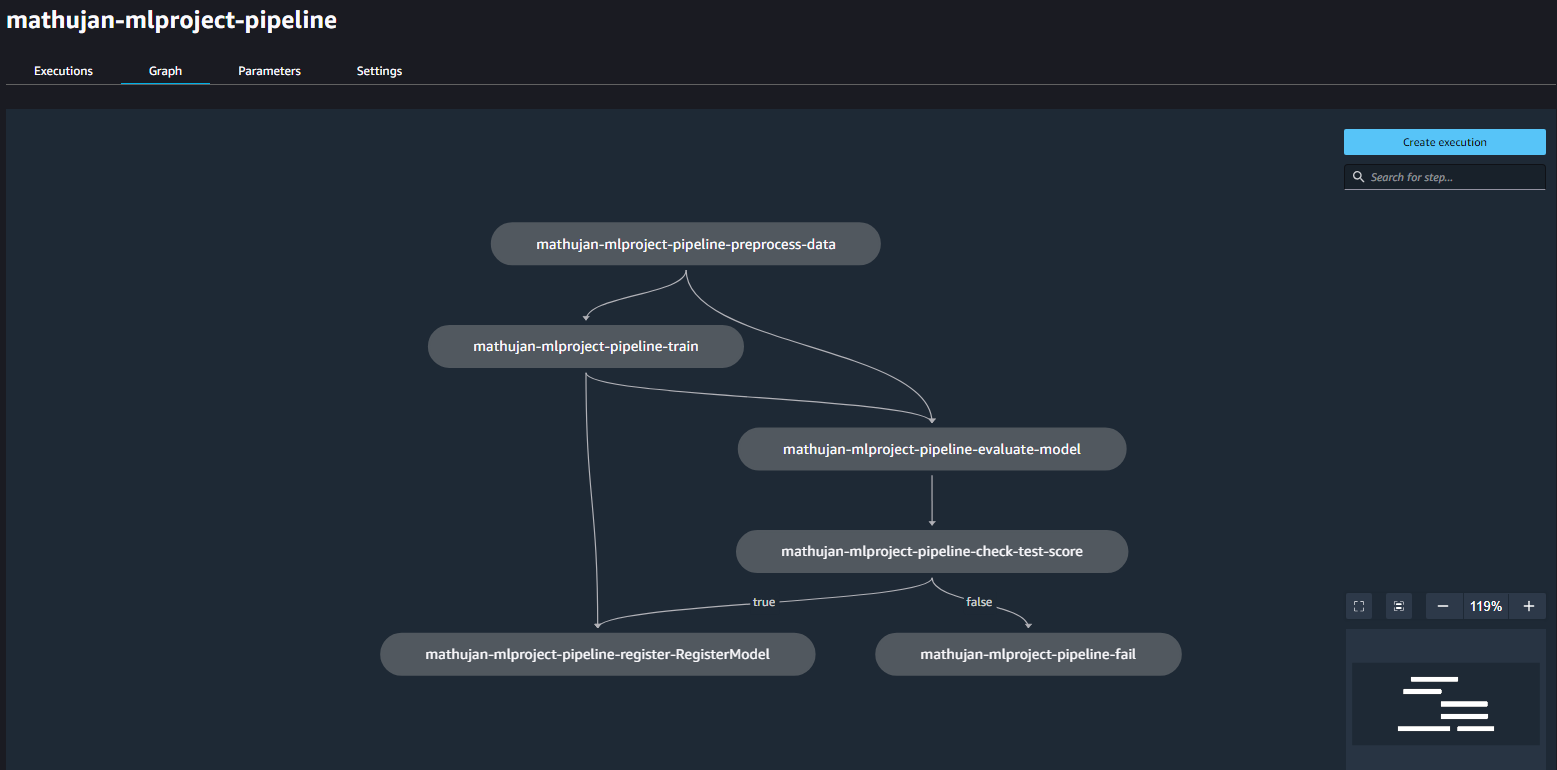

In [99]:
# Create a new or update existing Pipeline
pipeline.upsert(role_arn=sm_role)

{'PipelineArn': 'arn:aws:sagemaker:eu-north-1:058264187904:pipeline/mathujan-mlproject-pipeline',
 'ResponseMetadata': {'RequestId': 'd34618f4-4cd6-4b7d-8bf4-12500ae1532b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd34618f4-4cd6-4b7d-8bf4-12500ae1532b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '96',
   'date': 'Sat, 27 Jan 2024 05:19:30 GMT'},
  'RetryAttempts': 0}}

In [100]:
pipeline_definition = json.loads(pipeline.describe()['PipelineDefinition'])
pipeline_definition

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.t3.medium'},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'TrainingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'TestScoreThreshold', 'Type': 'Float', 'DefaultValue': 0.75},
  {'Name': 'InputDataUrl',
   'Type': 'String',
   'DefaultValue': 's3://mathujan-mlproject/mlproject/xgboost/input/bank-additional-full.csv'}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'mathujan-mlproject-pipeline-preprocess-data',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': {'Get': 'Parameters.ProcessingInstanceType'},
      'Ins

## Execute the pipeline
The following code starts an execution of the pipeline with the specified parameters.

In [101]:
execution = pipeline.start(
    parameters=dict(
        ProcessingInstanceType=process_instance_type,
        TrainingInstanceType=train_instance_type,
        TrainingInstanceCount=train_instance_count,
        ModelApprovalStatus="PendingManualApproval",
        TestScoreThreshold=0.75,
        InputDataUrl=input_s3_url
    )
)

In [ ]:
# Un-comment this call if you want the notebook to wait until the pipeline's execution finished
# Execution time of this pipeline is about 30 minutes
# execution.wait()

In [105]:
execution.list_steps()

[{'StepName': 'mathujan-mlproject-pipeline-register-RegisterModel',
  'StartTime': datetime.datetime(2024, 1, 27, 5, 49, 21, 533000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 1, 27, 5, 49, 22, 609000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'AttemptCount': 1,
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:eu-north-1:058264187904:model-package/mathujan-mlproject-model-group/1'}}},
 {'StepName': 'mathujan-mlproject-pipeline-check-test-score',
  'StartTime': datetime.datetime(2024, 1, 27, 5, 49, 20, 568000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 1, 27, 5, 49, 21, 82000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'AttemptCount': 1,
  'Metadata': {'Condition': {'Outcome': 'True'}}},
 {'StepName': 'mathujan-mlproject-pipeline-evaluate-model',
  'StartTime': datetime.datetime(2024, 1, 27, 5, 35, 15, 674000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 1, 27, 5, 49, 19, 454000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded'

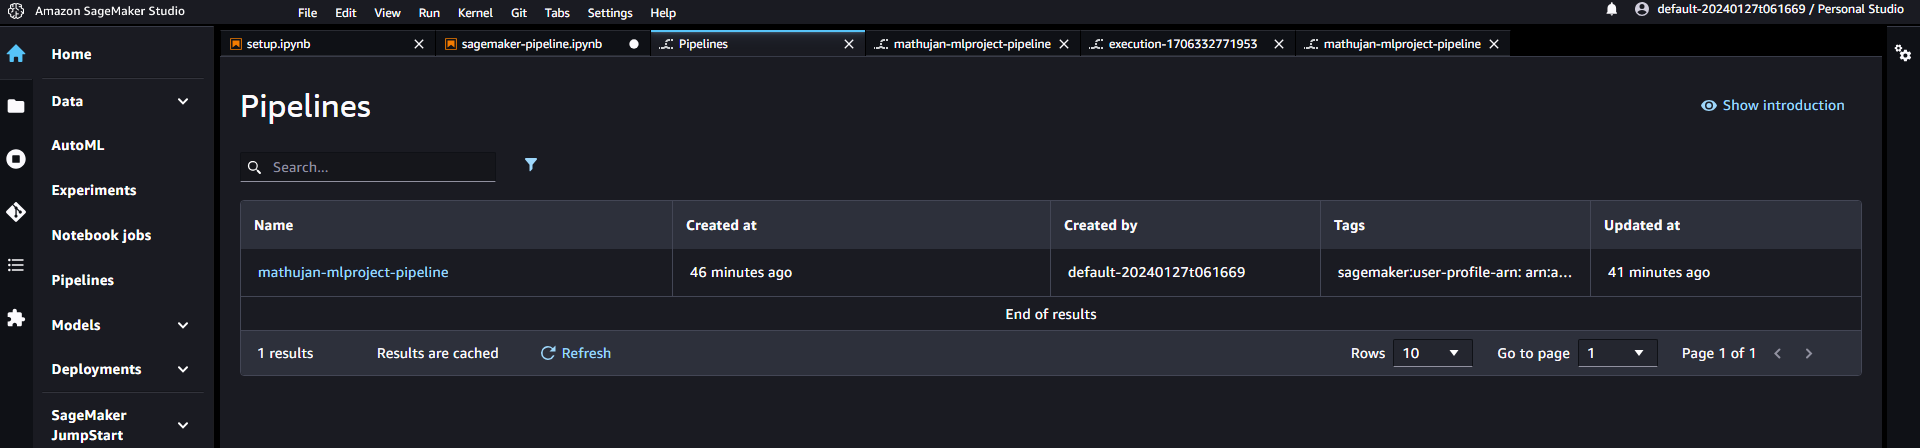

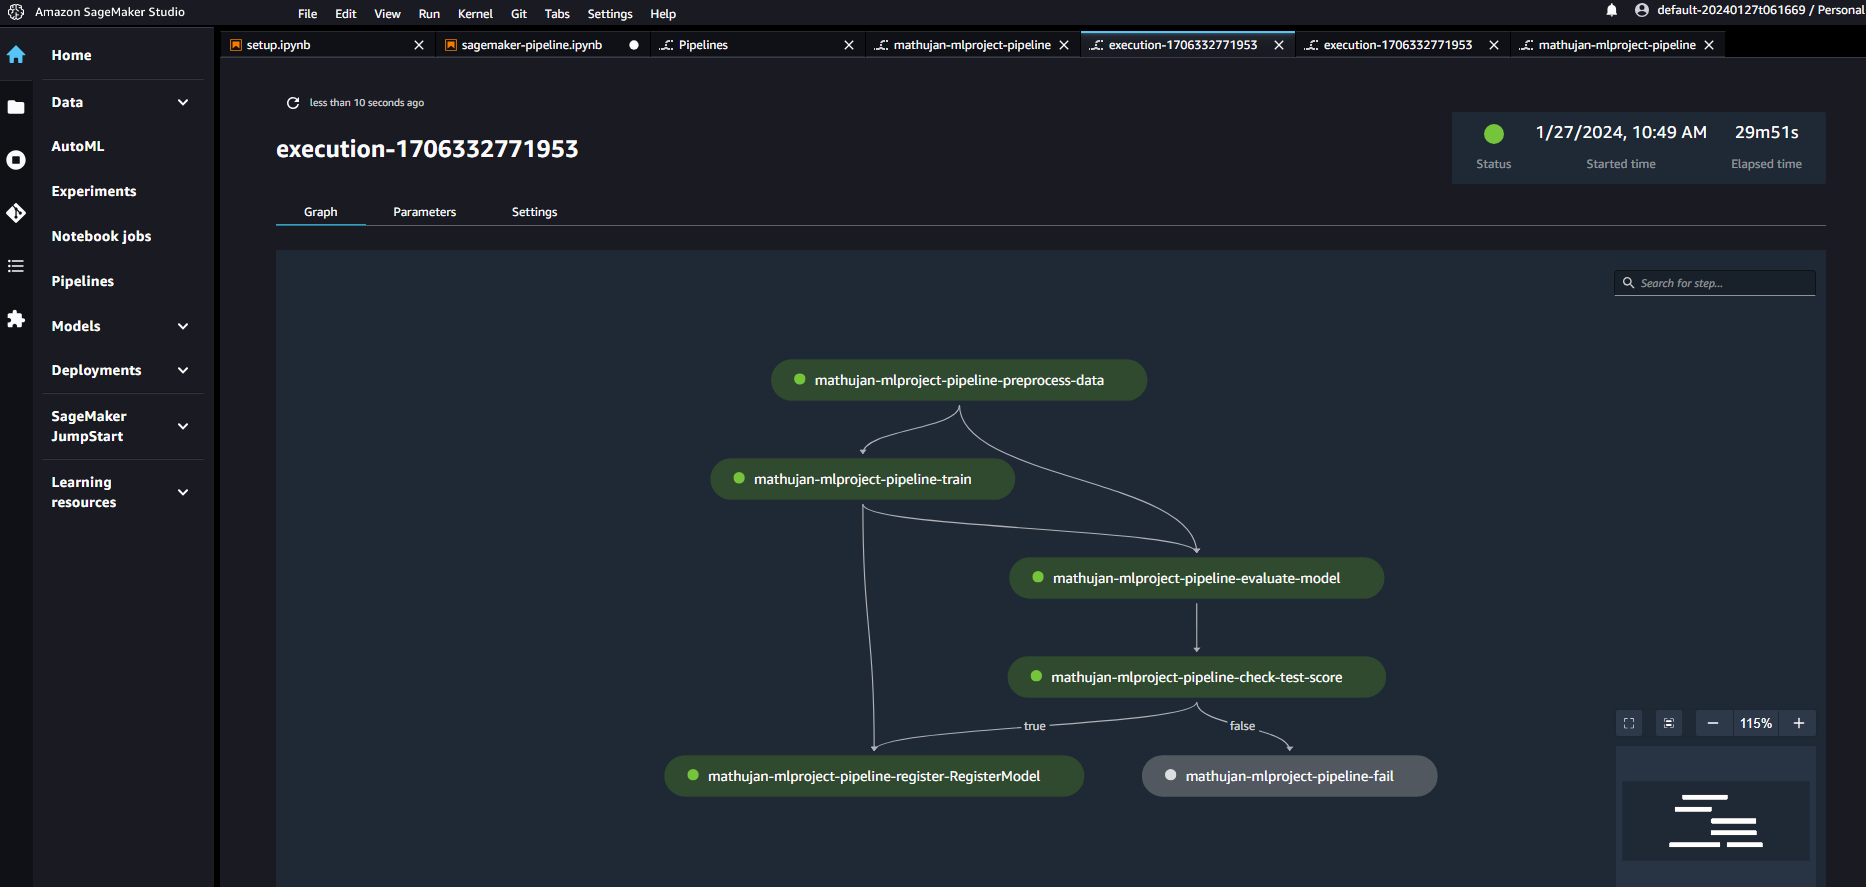

## Batch transform in the pipeline
You can integrate a batch transform step using the trained model in the pipeline.

In [106]:
from sagemaker.transformer import Transformer
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep
from sagemaker.inputs import CreateModelInput

In [107]:
# First, create a SageMaker model for the transform
model = Model(
    image_uri=xgboost_image_uri,        
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    name=f"mathujan-mlproject-xgboost-model",
    sagemaker_session=session,
    role=sm_role,
)

# Define create model step
step_create_model = ModelStep(
    name=f"{pipeline_name}-model",
    step_args=model.create(instance_type="ml.m5.large", accelerator_type="ml.eia1.medium"),
)

In [136]:
# Use the defined model to create a transformer
transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.large",
    instance_count=1,
    accept="text/csv",
    assemble_with="Line",
    output_path=f"s3://{bucket_name}/{bucket_prefix}/transform",
    sagemaker_session=session,
)
    
transform_args = transformer.transform(    
    data=step_process.properties.ProcessingOutputConfig.Outputs["test_data"].S3Output.S3Uri,
    content_type="text/csv",
    split_type="Line", 
)
            
# Create the transform step
step_transform = TransformStep(
    name=f"{pipeline_name}-transform", 
    step_args=transform_args,
)

In [137]:
# Add create model, register model, and transform steps to the "true" branch of the condition
step_cond = ConditionStep(
    name=f"{pipeline_name}-check-test-score",
    conditions=[cond_lte],
    if_steps=[step_create_model, step_register, step_transform],
    else_steps=[step_fail],
)

In [138]:
# Create the pipeline
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        process_instance_type_param,
        train_instance_type_param,
        train_instance_count_param,
        model_approval_status_param,
        test_score_threshold_param,
        input_s3_url_param,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
    sagemaker_session=session,
)

The new pipeline contains now the steps for creating the model and executing batch transform:

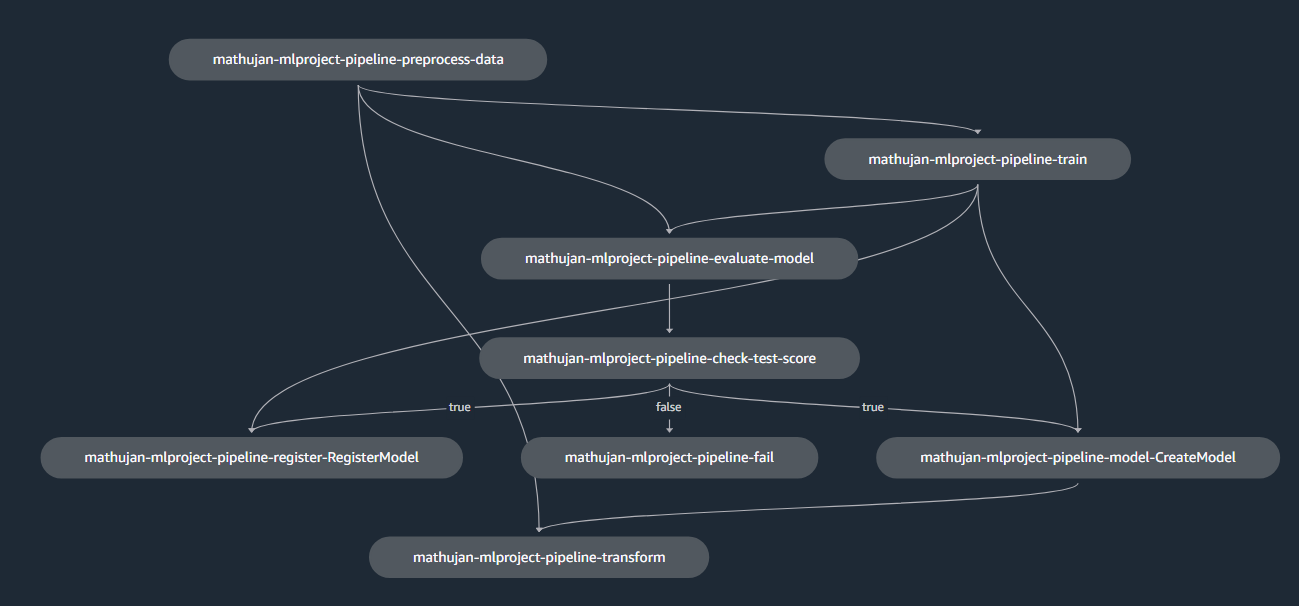

Optionally you can start the new pipeline execution:

In [139]:
pipeline.upsert(role_arn=sm_role)

{'PipelineArn': 'arn:aws:sagemaker:eu-north-1:058264187904:pipeline/mathujan-mlproject-pipeline',
 'ResponseMetadata': {'RequestId': 'a0dc399e-0c0b-45b1-8824-b346a0882e0f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a0dc399e-0c0b-45b1-8824-b346a0882e0f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '96',
   'date': 'Sat, 27 Jan 2024 09:58:55 GMT'},
  'RetryAttempts': 0}}

In [140]:
execution = pipeline.start(
    parameters=dict(
        ProcessingInstanceType=process_instance_type,
        TrainingInstanceType=train_instance_type,
        TrainingInstanceCount=train_instance_count,
        ModelApprovalStatus="PendingManualApproval",
        TestScoreThreshold=0.75,
        InputDataUrl=input_s3_url
    )
)

In [142]:
execution.list_steps()

[{'StepName': 'mathujan-mlproject-pipeline-transform',
  'StartTime': datetime.datetime(2024, 1, 27, 10, 28, 40, 67000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 1, 27, 10, 28, 41, 349000, tzinfo=tzlocal()),
  'StepStatus': 'Failed',
  'AttemptCount': 1,
  'FailureReason': "ClientError: Failed to invoke sagemaker:CreateTransformJob. Error Details: The account-level service limit 'ml.m5.large for transform job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota.\nRetry not appropriate on execution of step with PipelineExecutionArn arn:aws:sagemaker:eu-north-1:058264187904:pipeline/mathujan-mlproject-pipeline/execution/wmoo6gvyu3ry and StepId mathujan-mlproject-pipeline-transform. No retry policy configured for the exception type SAGEMAKER_RESOURCE_LIMIT.",
  'Met

# Shutdown kernel

In [143]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>